## Imports

In [35]:
import jax
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

%matplotlib inline

## K-armed Bandit Problem

A simple version of the k-armed bandit problem is useful because of its nonassociative nature. This is a good problem or environement to learn basic reinforcement learning methodes.

So let's create a simple gymnasium environement to re-create the k-armed bandit problem.

### The k-armed bandit problem

You are faced repeatedly with a choice among
k di↵erent options, or actions. After each choice you receive a numerical reward chosen
from a stationary probability distribution that depends on the action you selected. Your objective is to maximize the expected total reward over some time period, for example,
over 1000 action selections, or time steps.

In [36]:
class KArmedBandit(gym.Env):

    def __init__(self, nb_arms=10, nb_steps=1000):
        self._nb_arms = nb_arms
        self._nb_steps = nb_steps

        self.action_space = gym.spaces.Discrete(nb_arms)
        self.observation_space = gym.spaces.Discrete(1)
    
    def step(self, action):
        self._step += 1
    
        reward = self._arms[action]
        reward_noise = jax.random.normal(jax.random.key(self._step), (1))[0] # self.np_random.normal(0, 1, size=1)[0]
        terminated = self._step >= self._nb_steps

        info = { "is_optimal_action": int(action == np.argmax(self._arms)) }

        return reward + reward_noise, terminated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self._step = 0
        self._arms = self.np_random.normal(0, 1, size=self._nb_arms)


let's see if the implementation of the k-armed bandit is correct:

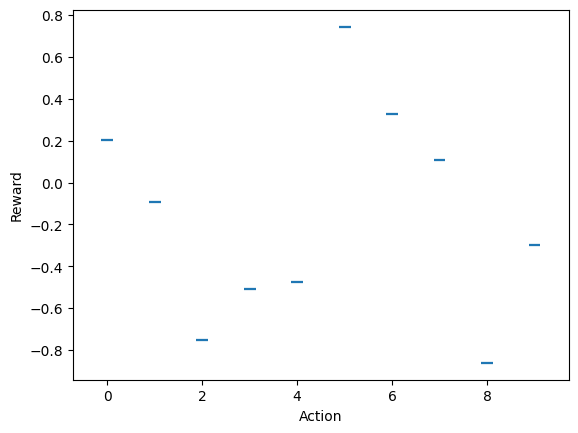

In [37]:
env = KArmedBandit(nb_arms=10)
env.reset()

# Sample our distribution to see it's correct
data = np.array([[env.step(i)[0] for i in range(len(env._arms))] for _ in range(100)])
index = [i for i in range(len(env._arms))]

plt.violinplot(data, index, showmeans=True)

plt.xlabel('Action')
plt.ylabel('Reward')

plt.show()

It seems good !

In [4]:
class EpsilonGreedy():

    def __init__(self, nb_actions, epsilon):
        self.nb_actions = nb_actions
        self.epsilon = epsilon

        self.sum_of_rewards = np.zeros(self.nb_actions)
        self.nb_action_taken = np.ones(self.nb_actions)

    def action(self):
        take_random_action_prob = np.random.uniform(0, 1)

        if take_random_action_prob < self.epsilon:
            return np.random.randint(0, self.nb_actions)
        else:
            return np.argmax(self.sum_of_rewards / self.nb_action_taken)
    
    def observe(self, action, reward):
        self.sum_of_rewards[action] += reward
        self.nb_action_taken[action] += 1
    
    def reset(self):
        self.sum_of_rewards = np.zeros(self.nb_actions)
        self.nb_action_taken = np.ones(self.nb_actions)

In "-greedy action selection, for the case of two actions and " = 0.5, what is
the probability that the greedy action is selected?

Well, there is a probability of 0.5 to take the greedy action then 0.5 to take a random action; in this case there is a 1/2 chance to take the greedy action.
So the answer is 0.5 + (0.5 * 0.5) = 0.75 

In [5]:
env = KArmedBandit(nb_arms=10)
agent = EpsilonGreedy(nb_actions=10, epsilon=0.01)

In [6]:
def run_env(env, agent):
    list_of_reward = []
    list_of_optimal_action = []

    env.reset()
    agent.reset()

    terminated = False

    while not terminated:
        action = agent.action()

        reward, terminated, info = env.step(action)

        agent.observe(action, reward)

        list_of_reward.append(reward)
        list_of_optimal_action.append(info["is_optimal_action"])
    
    return np.array(list_of_reward), np.array(list_of_optimal_action)

In [7]:
list_of_reward, list_of_optimal_action = run_env(env, agent)

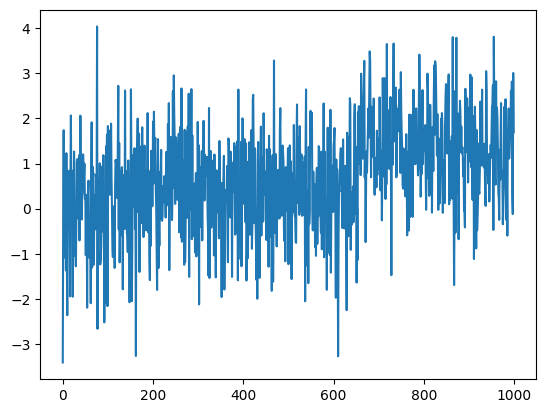

In [8]:
plt.plot(list_of_reward)
plt.show()

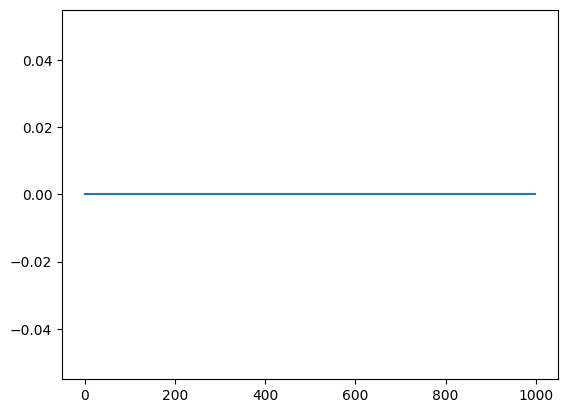

In [9]:
plt.plot(list_of_optimal_action)
plt.show()

It's hard to see any result here, there is to much noise.

Repeating this for 2000 independent runs,
each with a di↵erent bandit problem, we obtained measures of the learning algorithm’s
average behavior.

In [10]:
def run_exp(nb_exps, env, agent):
    list_rewards, list_optimal_action = run_env(env, agent)

    for _ in range(nb_exps - 1):
        list_rewards_tmp, list_optimal_action_tmp = run_env(env, agent)

        list_rewards += list_rewards_tmp
        list_optimal_action += list_optimal_action_tmp

    return list_rewards / nb_exps, (list_optimal_action / nb_exps) * 100

In [11]:
env = KArmedBandit(nb_arms=10)
env.reset()

In [12]:
agent_01 = EpsilonGreedy(nb_actions=10, epsilon=0.01)
mean_rewards_01, percent_optimal_action_01 = run_exp(2000, env, agent_01)

In [13]:
agent_1 = EpsilonGreedy(nb_actions=10, epsilon=0.1)
mean_rewards_1, percent_optimal_action_1 = run_exp(2000, env, agent_1)

In [14]:
agent_greedy = EpsilonGreedy(nb_actions=10, epsilon=0.0)
mean_rewards_0, percent_optimal_action_0 = run_exp(2000, env, agent_greedy)

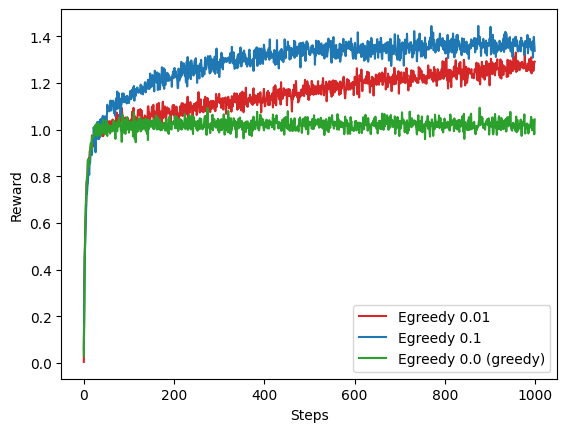

In [15]:
plt.plot(mean_rewards_01, color="tab:red", label='Egreedy 0.01')

plt.plot(mean_rewards_1, color="tab:blue", label='Egreedy 0.1')

plt.plot(mean_rewards_0, color="tab:green", label='Egreedy 0.0 (greedy)')

plt.xlabel('Steps')
plt.ylabel('Reward')

plt.legend()
plt.show()

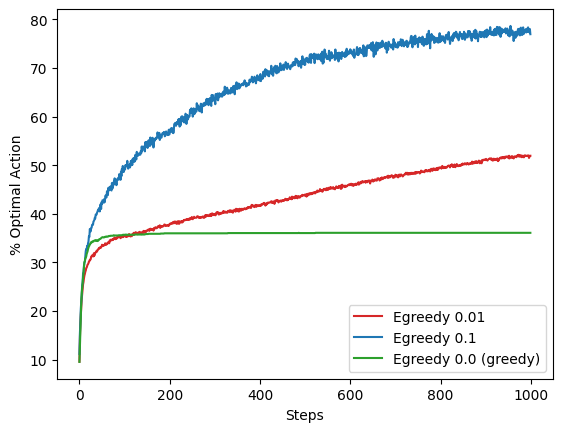

In [16]:
plt.plot(percent_optimal_action_01, color="tab:red", label='Egreedy 0.01')

plt.plot(percent_optimal_action_1, color="tab:blue", label='Egreedy 0.1')

plt.plot(percent_optimal_action_0, color="tab:green", label='Egreedy 0.0 (greedy)')

plt.xlabel('Steps')
plt.ylabel('% Optimal Action')

plt.legend()
plt.show()

## Incremental Implementation

In [17]:
class EpsilonGreedy():

    def __init__(self, nb_actions, epsilon):
        self.nb_actions = nb_actions
        self.epsilon = epsilon

        self.q = np.zeros(self.nb_actions)
        self.nb_action_taken = np.ones(self.nb_actions)

    def action(self):
        take_random_action_prob = np.random.uniform(0, 1)

        if take_random_action_prob < self.epsilon:
            return np.random.randint(0, self.nb_actions)
        else:
            return np.argmax(self.q)
    
    def observe(self, action, reward):
        self.nb_action_taken[action] += 1
        self.q[action] += (reward - self.q[action]) / self.nb_action_taken[action]
    
    def reset(self):
        self.q = np.zeros(self.nb_actions)
        self.nb_action_taken = np.ones(self.nb_actions)

In [18]:
env = KArmedBandit(nb_arms=10)
env.reset()

In [19]:
agent_01 = EpsilonGreedy(nb_actions=10, epsilon=0.01)
mean_rewards_01, percent_optimal_action_01 = run_exp(2000, env, agent_01)

In [20]:
agent_1 = EpsilonGreedy(nb_actions=10, epsilon=0.1)
mean_rewards_1, percent_optimal_action_1 = run_exp(2000, env, agent_1)

In [21]:
agent_greedy = EpsilonGreedy(nb_actions=10, epsilon=0.0)
mean_rewards_0, percent_optimal_action_0 = run_exp(2000, env, agent_greedy)

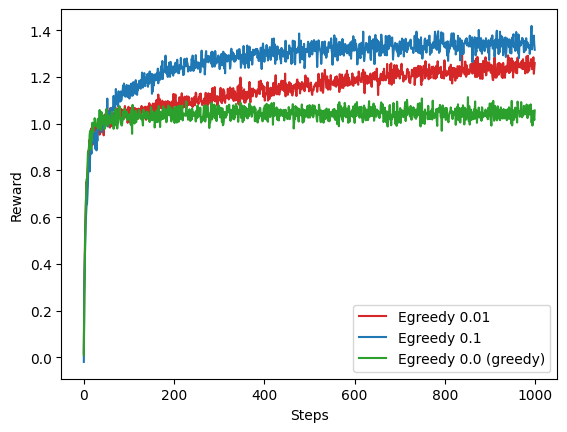

In [22]:
plt.plot(mean_rewards_01, color="tab:red", label='Egreedy 0.01')

plt.plot(mean_rewards_1, color="tab:blue", label='Egreedy 0.1')

plt.plot(mean_rewards_0, color="tab:green", label='Egreedy 0.0 (greedy)')

plt.xlabel('Steps')
plt.ylabel('Reward')

plt.legend()
plt.show()

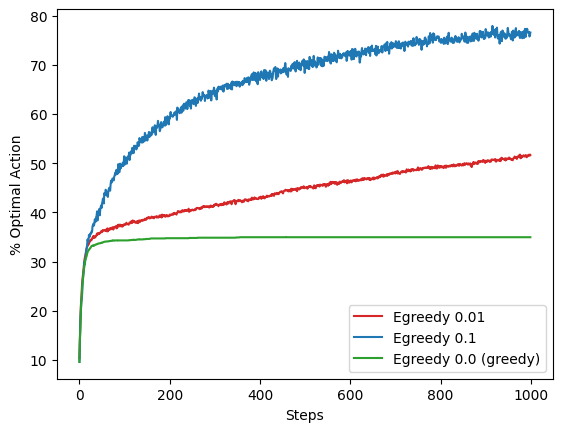

In [23]:
plt.plot(percent_optimal_action_01, color="tab:red", label='Egreedy 0.01')

plt.plot(percent_optimal_action_1, color="tab:blue", label='Egreedy 0.1')

plt.plot(percent_optimal_action_0, color="tab:green", label='Egreedy 0.0 (greedy)')

plt.xlabel('Steps')
plt.ylabel('% Optimal Action')

plt.legend()
plt.show()

### Optimistic greedy

In [24]:
class EpsilonGreedy():

    def __init__(self, nb_actions, epsilon, alpha, optimistic_value=0):
        self.nb_actions = nb_actions
        self.epsilon = epsilon
        self.alpha = alpha
        self.optimistic_value = optimistic_value

        self.q = np.ones(self.nb_actions) * optimistic_value

    def action(self):
        take_random_action_prob = np.random.uniform(0, 1)

        if take_random_action_prob < self.epsilon:
            return np.random.randint(0, self.nb_actions)
        else:
            return np.argmax(self.q)
    
    def observe(self, action, reward):
        self.q[action] += self.alpha * (reward - self.q[action])
    
    def reset(self):
        self.q = np.ones(self.nb_actions) * self.optimistic_value

In [25]:
env = KArmedBandit(nb_arms=10)
env.reset()

In [26]:
agent_optimistic = EpsilonGreedy(nb_actions=10, epsilon=0.01, alpha=0.1, optimistic_value=5)
mean_rewards_optimistic, percent_optimal_action_optimistic = run_exp(2000, env, agent_optimistic)

In [27]:
agent_non_otpimistic = EpsilonGreedy(nb_actions=10, epsilon=0.01, alpha=0.1, optimistic_value=0)
mean_rewards_non_optimistic, percent_optimal_action_non_optimistic = run_exp(2000, env, agent_non_otpimistic)

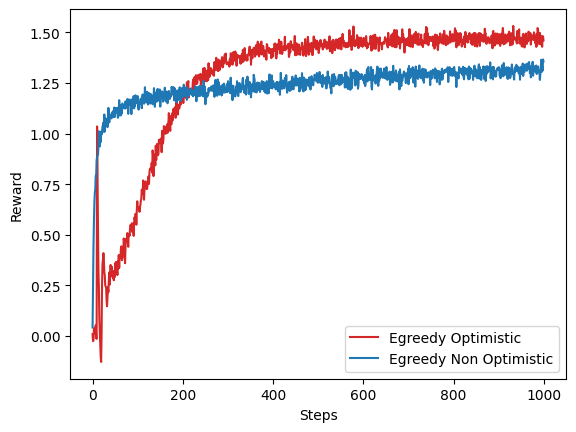

In [28]:
plt.plot(mean_rewards_optimistic, color="tab:red", label='Egreedy Optimistic')

plt.plot(mean_rewards_non_optimistic, color="tab:blue", label='Egreedy Non Optimistic')

plt.xlabel('Steps')
plt.ylabel('Reward')

plt.legend()
plt.show()

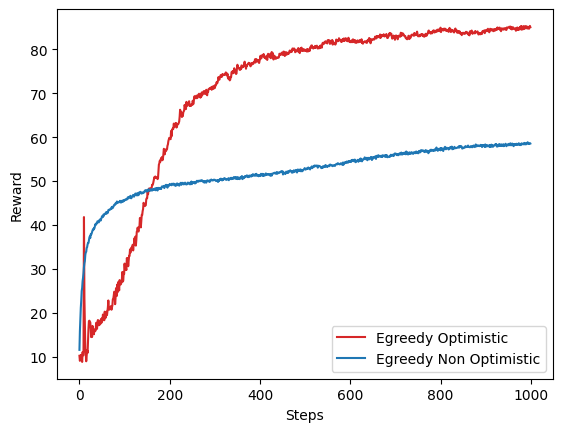

In [29]:
plt.plot(percent_optimal_action_optimistic, color="tab:red", label='Egreedy Optimistic')

plt.plot(percent_optimal_action_non_optimistic, color="tab:blue", label='Egreedy Non Optimistic')

plt.xlabel('Steps')
plt.ylabel('Reward')

plt.legend()
plt.show()

## Upper-Confidence-Bound

In [30]:
class UpperConfidenceBound():

    def __init__(self, nb_actions, confidence, alpha):
        self.nb_actions = nb_actions
        self.confidence = confidence
        self.alpha = alpha

        self.q = np.zeros(self.nb_actions)
        self.nb_action_taken = np.zeros(self.nb_actions)
        self.upper_configdence = np.zeros(self.nb_actions)

    def action(self):
        return np.argmax(self.q + self.upper_configdence)
    
    def observe(self, action, reward):
        self.q[action] += self.alpha * (reward - self.q[action])

        self.nb_action_taken[action] += 1

        self.upper_configdence = self.confidence * np.sqrt(np.log(np.sum(self.nb_action_taken)) / self.nb_action_taken)
    
    def reset(self):
        self.q = np.zeros(self.nb_actions)
        self.nb_action_taken = np.zeros(self.nb_actions)
        self.upper_configdence = np.zeros(self.nb_actions)

In [31]:
env = KArmedBandit(nb_arms=10)
env.reset()

In [32]:
upper_condidence_agent = UpperConfidenceBound(nb_actions=10, confidence=2, alpha=0.1)
mean_rewards_upper_confidence, percent_optimal_action_upper_confidence = run_exp(2000, env, upper_condidence_agent)

/tmp/ipykernel_101987/155911985.py:20: RuntimeWarning: invalid value encountered in divide
  self.upper_configdence = self.confidence * np.sqrt(np.log(np.sum(self.nb_action_taken)) / self.nb_action_taken)
/tmp/ipykernel_101987/155911985.py:20: RuntimeWarning: divide by zero encountered in divide
  self.upper_configdence = self.confidence * np.sqrt(np.log(np.sum(self.nb_action_taken)) / self.nb_action_taken)


In [33]:
egreedy_agent = EpsilonGreedy(nb_actions=10, epsilon=0.01, alpha=0.1, optimistic_value=0)
mean_rewards_egreedy, percent_optimal_action_egreedy = run_exp(2000, env, egreedy_agent)

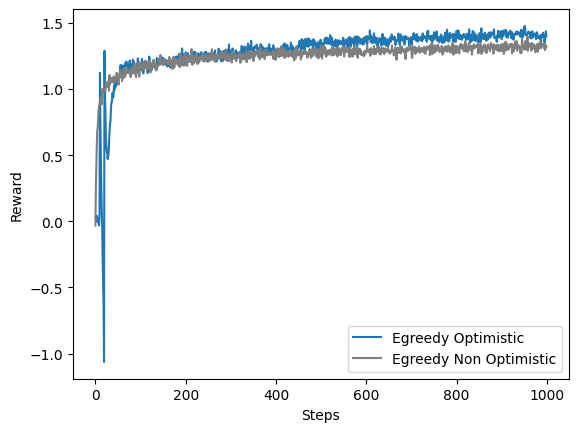

In [34]:
plt.plot(mean_rewards_upper_confidence, color="tab:blue", label='Egreedy Optimistic')

plt.plot(mean_rewards_egreedy, color="tab:gray", label='Egreedy Non Optimistic')

plt.xlabel('Steps')
plt.ylabel('Reward')

plt.legend()
plt.show()